In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import set_param_freq
from toolbox.symbolic_SINDy import symbolic_SINDy

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


### Case $\rho$ fixed
Consider the following fractional system of ODEs: 
$$
\begin{cases}
\dot{x}_0 = \dfrac{x_0^2}{x_1 + \rho} \\[10pt]
\dot{x}_1 = 1
\end{cases}
$$

With $\rho=2$ fixed.

In [ ]:
# Select ODE & settings:
ode_name = 'FracODE' # help="name of the ode", type=str
ode_param = '2.' # '1.' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
freq_SR = 10 # help="number of trajectories", type=int, default=100
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 0
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [ ]:
# # Generate data:
# X_list, dX_list, param_list, feature_names = SINDy_data.SINDy_data(ode_name, ode_param, freq, n_sample, noise_ratio, dim_x, dim_k)
# print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
# print(feature_names)

# # Save data:
# file_path = 'saved/data/fracODE_data.pkl'
# os.makedirs(os.path.dirname(file_path), exist_ok=True)
# with open(file_path, 'wb') as f:
#     dill.dump((X_list, dX_list, param_list, feature_names), f)

In [4]:
# Uploda data:
file_path = 'saved/data/fracODE_data.pkl'
with open(file_path, 'rb') as f:
    X_list, dX_list, param_list, feature_names = dill.load(f)

print(np.shape(X_list), np.shape(dX_list), np.shape(param_list))
print(feature_names)

(50, 30, 2) (50, 30, 2) (0,)
['X0', 'X1']


In [8]:
# Symbolic-SINDy call and fit
model = symbolic_SINDy(SR_method='SR-T', 
                       x_id=0,
                       degree=2,
                       threshold=0.2,
                       product=True)
final_model, building_blocks_lambda, _, _, _, _ =  model.call(X_list=X_list, dX_list=dX_list, param_list=param_list,
           feature_names=feature_names, dt=dt, building_blocks_lambda=None, 
           function_names=None, patience=0, lazy=True, ode=ode, ode_name=ode_name,
           ode_param=ode_param, freq_SR=freq_SR, n_sample=n_sample, 
           noise_ratio=noise_ratio, seed=seed, n_seed=n_seed, 
           T0=0, T=T, dim_x=dim_x, dim_k=dim_k)


Searching for the best building block:
Model:
(X0)' = 0.991 X0^2 1/(X1 + 1.9972309850338754)
(X1)' = 0.998 1
errors:  [0.01999643993524796]

Best building block:
['1/(X1 + 1.9972309850338754)']

Smart-SINDy model:
(X0)' = 0.991 X0^2 1/(X1 + 1.9972309850338754)
(X1)' = 0.998 1
Model complexity:  2
Lasso penalty:  1.9899068039920096


##### Plot for report

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low, dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux + dt, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    # Assumiamo che 'data' sia disponibile nell'ambiente
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()

    if n_sample == 1:
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)

        elif dim_x == 2:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            # INVERTIAMO x1 e x2 nei dati
            ax.plot(pred_0_list[:, 1], pred_0_list[:, 0],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 1], xt_true[:, 0],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 1][0], xt_true[:, 0][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 1][-1], xt_true[:, 0][-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')  # ORIZZONTALE → t
            ax.set_ylabel(r'$x$')  # VERTICALE → x
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)


        else:  # dim_x == 3
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='upper left')
            ax.grid(True)


Best Model RMSE:  0.007891340025282674


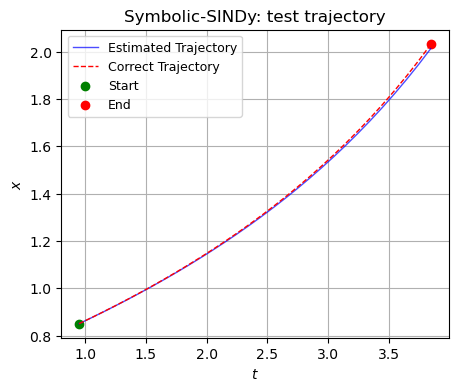

In [11]:
# Evaluation: within the training -> RMSE and reconstruction
n_test = 10
rmse, _ = SINDy_data.evaluate_RMSE(final_model, ode, freq, n_test, [1., 1.], [0.8, 0.8], dim_k)
print('Best Model RMSE: ', rmse)

evaluate_sample = 1
ics = [0.85, 0.95]
title = 'Symbolic-SINDy: test trajectory'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=3)

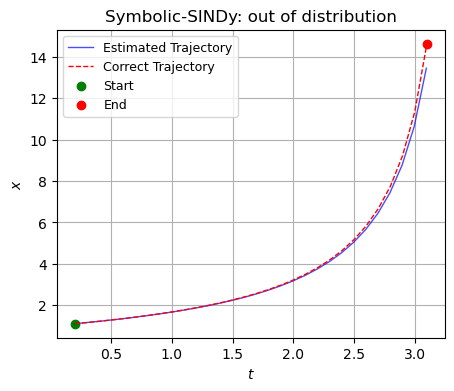

In [15]:
# Evaluation: outside the training set
evaluate_sample = 1
ics = [1.1, 0.2]
title = 'Symbolic-SINDy: out of distribution'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=3)

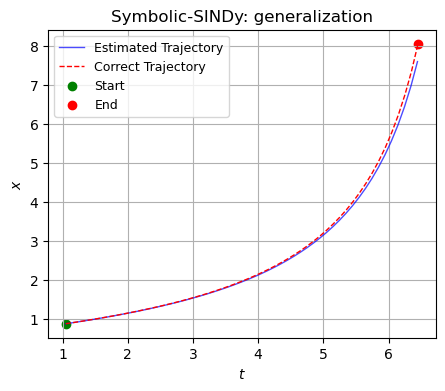

In [14]:
# Evaluation: Generalization for unseen time
evaluate_sample = 1
ics = [0.85, 0.95]
title = 'Symbolic-SINDy: generalization'
evaluate_traj(final_model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=5.5)